In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import nltk
import seaborn as sns
import os
from fuzzywuzzy import fuzz
from itertools import combinations

In [2]:
!ls '../Dados/SirioLibanes/'

'HSL_Dataset_Covid19_Dicionário de Dados.xlsx'	 hsl_lab_result_1.csv
'HSL Dataset final.Zip'				 hsl_patient_1.csv
 hsl_desfecho_1.csv				 hsl_small_dataset_fapesp.zip


## Lendo datasets

In [3]:
hsl_desfecho = pd.read_csv('../Dados/SirioLibanes/hsl_desfecho_1.csv', sep='|')
hsl_pacientes = pd.read_csv('../Dados/SirioLibanes/hsl_patient_1.csv', sep='|')
hsl_result = pd.read_csv('../Dados/SirioLibanes/hsl_lab_result_1.csv', sep='|')

In [4]:
hsl_result['count'] = 1

## Clustering exams

In [5]:
hsl_result.groupby(['DE_EXAME']).agg({'count':'sum'})

,count
DE_EXAME,
17 Alfa Hidroxiprogesterona,2
"Acido Ascorbico, plasma",6
Acido FĂłlico,112
"Adenovirus, Sorologia",1
AdenovĂ­rus PCR Quantitativo,1
...,...
"Ăcido MetilmalĂ´nico, Soro",1
"Ăcido ValprĂłico, Dosagem",1
Ăcido Ărico,155


In [6]:
df = hsl_result

In [7]:
# Getting all a list with the names of all the exams.
all_exams = df['DE_EXAME'].unique()

In [8]:
# Pairing exames with at least 80% if name similarity according to Levenstein's Distance
pairing_percentage = [ (i, j) for j in all_exams for i in all_exams if fuzz.ratio(i, j) > 80 and i != j]
pairing_percentage

[('Creatinofosfoquinase Cpk-Ck', 'Creatinofosfoquinase - CK-MB'),
 ('Creatinofosfoquinase - CK-MB', 'Creatinofosfoquinase Cpk-Ck'),
 ('Creatino Fosfoquinase (Cpk)', 'Creatinofosfoquinase Cpk-Ck'),
 ('PotĂĄssio (K)', 'PotĂĄssio'),
 ('ProteĂ\xadna C Reativa, soro', 'ProteĂ\xadna C Reativa, plasma'),
 ('Desidrogenase LĂĄtica  ( LDH )', 'Desidrogenase LĂĄtica (DHL/L)'),
 ('Fosfatase Alcalina, soro', 'Fosfatase Alcalina'),
 ('Hemocultura para anaerĂłbios, por maldi-tof, vĂĄrios materiais',
  'Hemocultura para aerĂłbios, por maldi-tof, vĂĄrios materiais'),
 ('Hemocultura para fungos, por maldi-tof, vĂĄrios materiais',
  'Hemocultura para aerĂłbios, por maldi-tof, vĂĄrios materiais'),
 ('Hemocultura para aerĂłbios, por maldi-tof, vĂĄrios materiais',
  'Hemocultura para anaerĂłbios, por maldi-tof, vĂĄrios materiais'),
 ('Hemocultura para fungos, por maldi-tof, vĂĄrios materiais',
  'Hemocultura para anaerĂłbios, por maldi-tof, vĂĄrios materiais'),
 ('Creatinofosfoquinase Cpk-Ck', 'Creatino Fos

In [9]:
aux = []
for i, j in pairing_percentage:
    aux.append(i)
    aux.append(j)

### Preparation for clustering...
We will first create our adjacency matrix through this list comprehension and rename it to the variable ```X```. This variable will be used in all the steps following.

**Important**: The function fuzz.ratio returns the **similarity** degree between two strings according to Levenstein's Distance, but we want to analyze the **distance** between these strings, so we're going to invert our values by subtracting from 100 each Levenstein's Distance value obtained. So, in the end, **the lower the value, the closer are the strings**.

In [10]:
adj_matrix = np.array([ np.array([ 100 - fuzz.ratio(i, j) for j in all_exams]) for i in all_exams])
X = adj_matrix

### Multidimensional Scaling (MDS)
Plotting our strings in a 2D space.

In [11]:
embedding = MDS(n_components=2)
mds = embedding.fit_transform(X)

/home/joaopedromattos/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


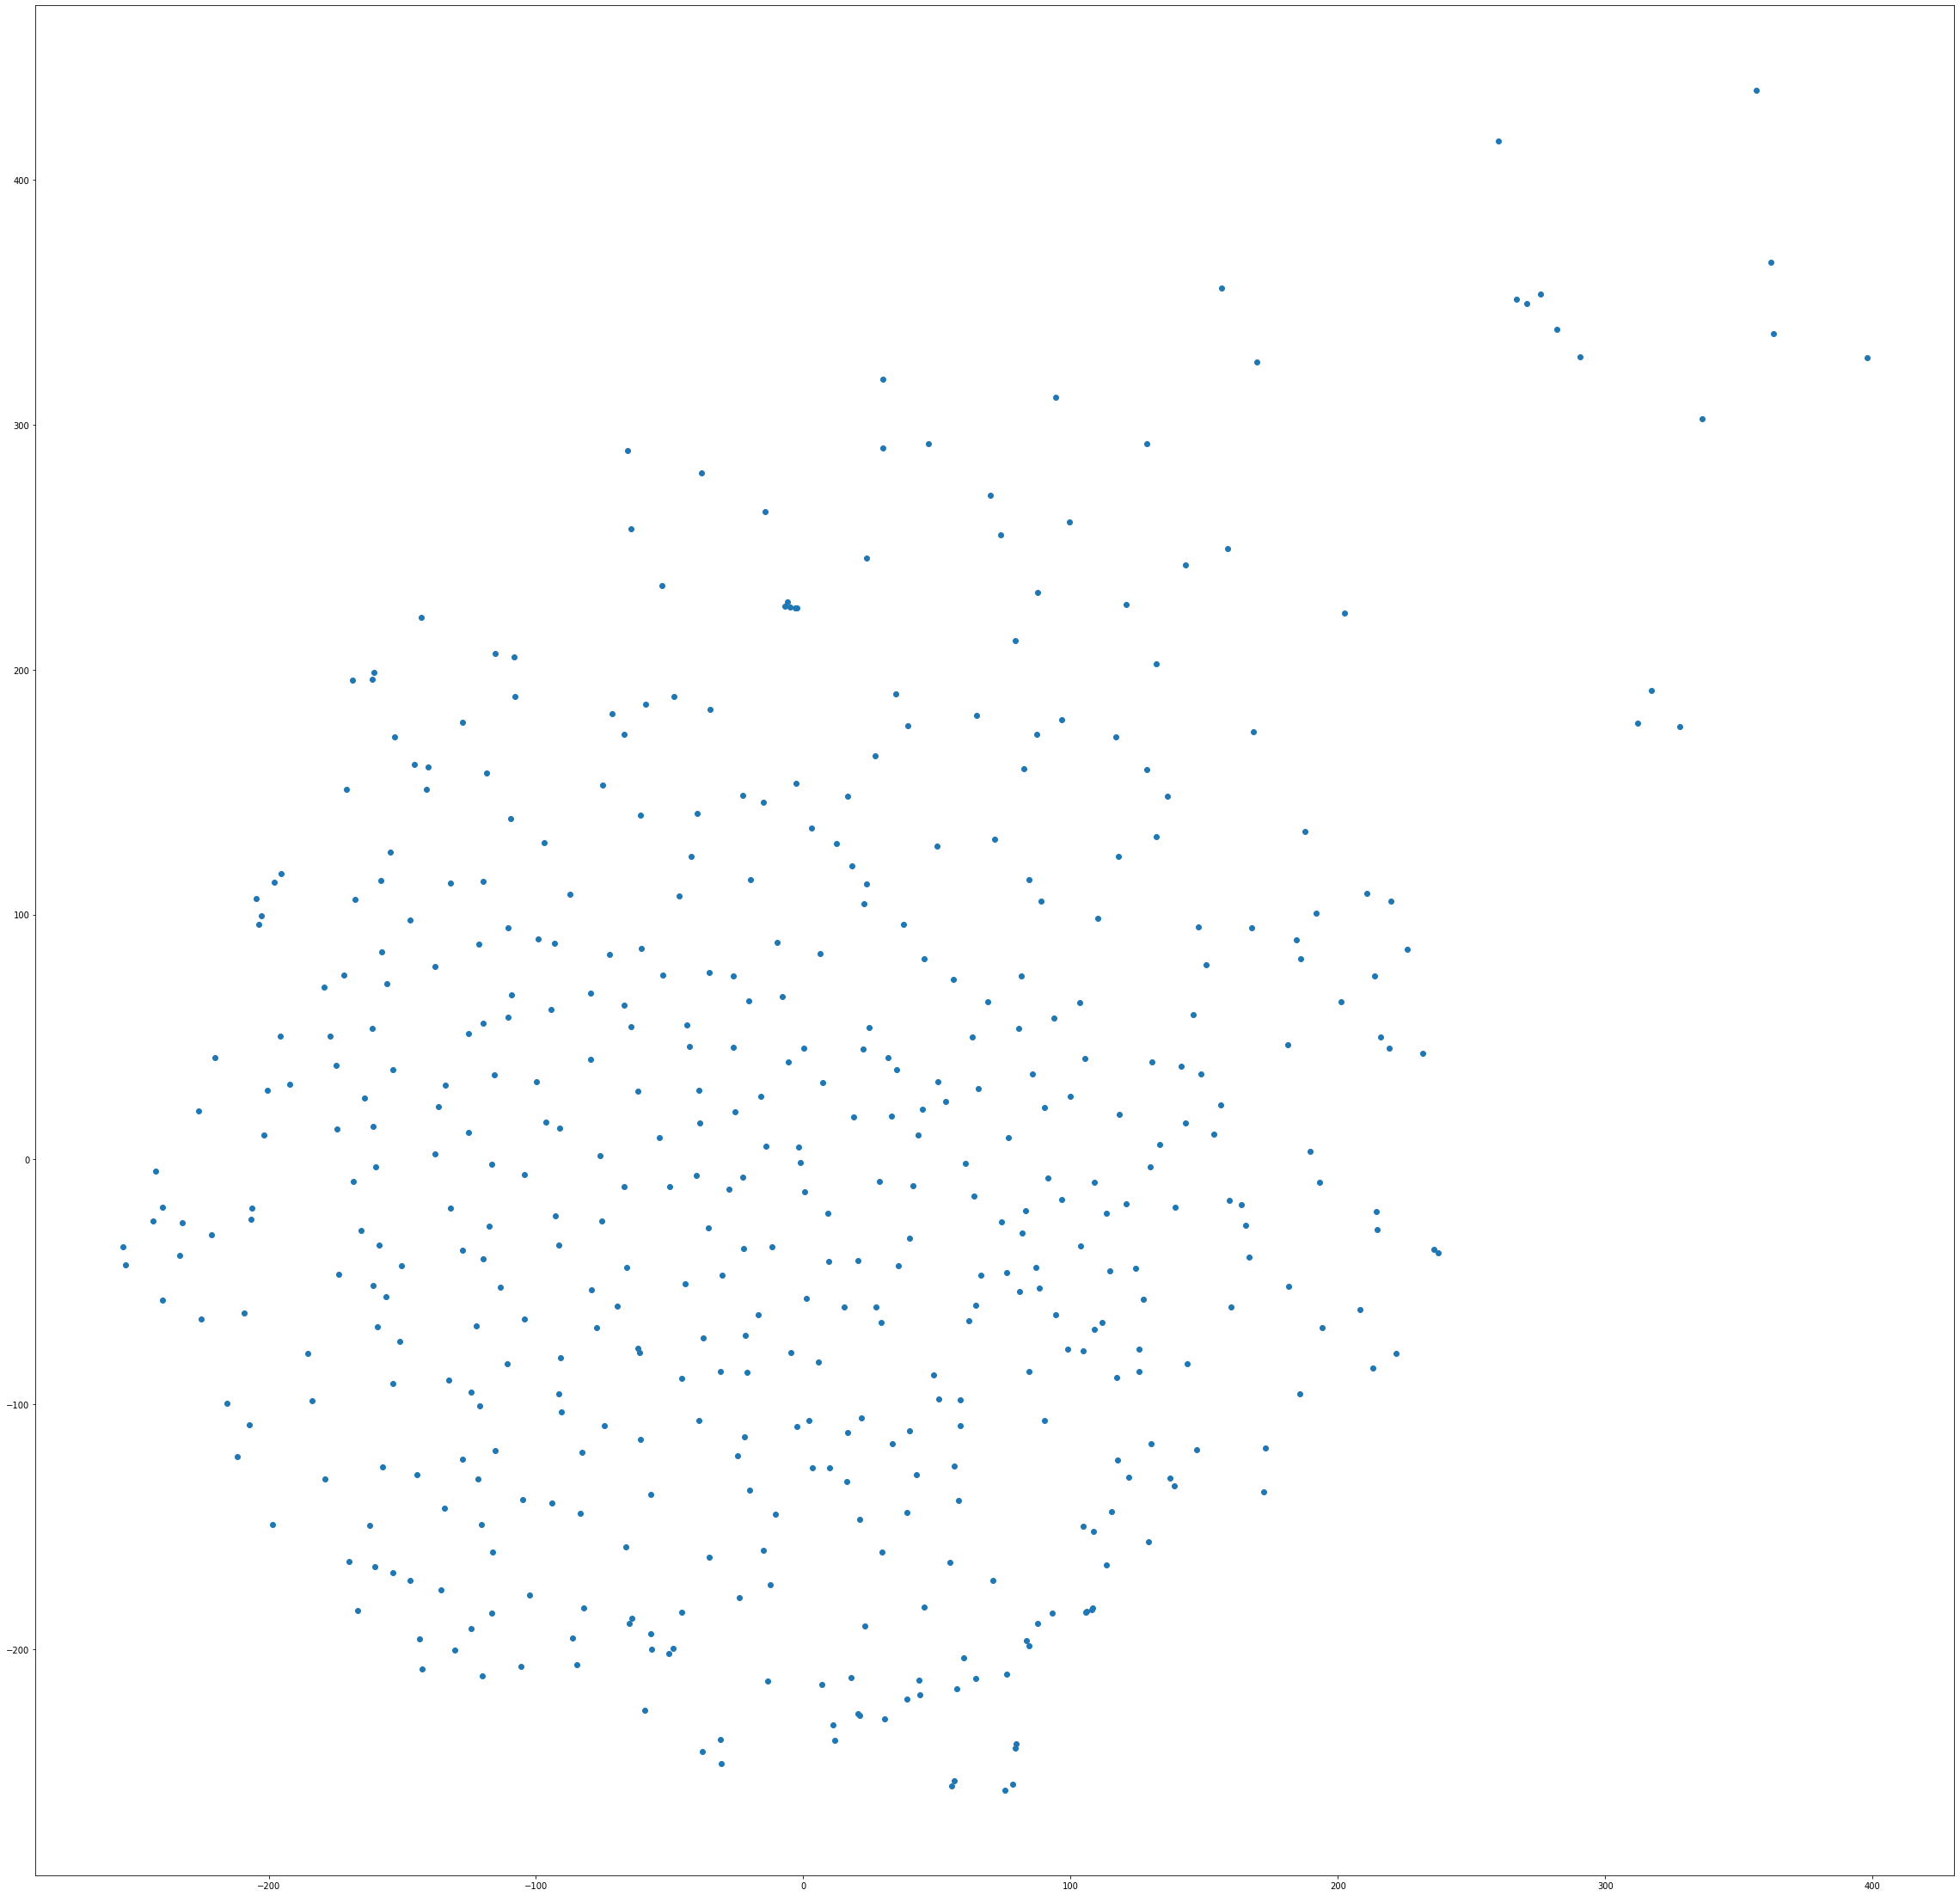

In [27]:
plt.rcParams['figure.figsize'] = 40, 40
plt.scatter(x=mds[:, 0], y=mds[:, 1])
plt.savefig('MDS')

/home/joaopedromattos/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/joaopedromattos/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/joaopedromattos/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/joaopedromattos/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 154 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/joaopedromattos/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/joaopedromattos/.local/lib/python3.8/site-packages/matplotlib/b

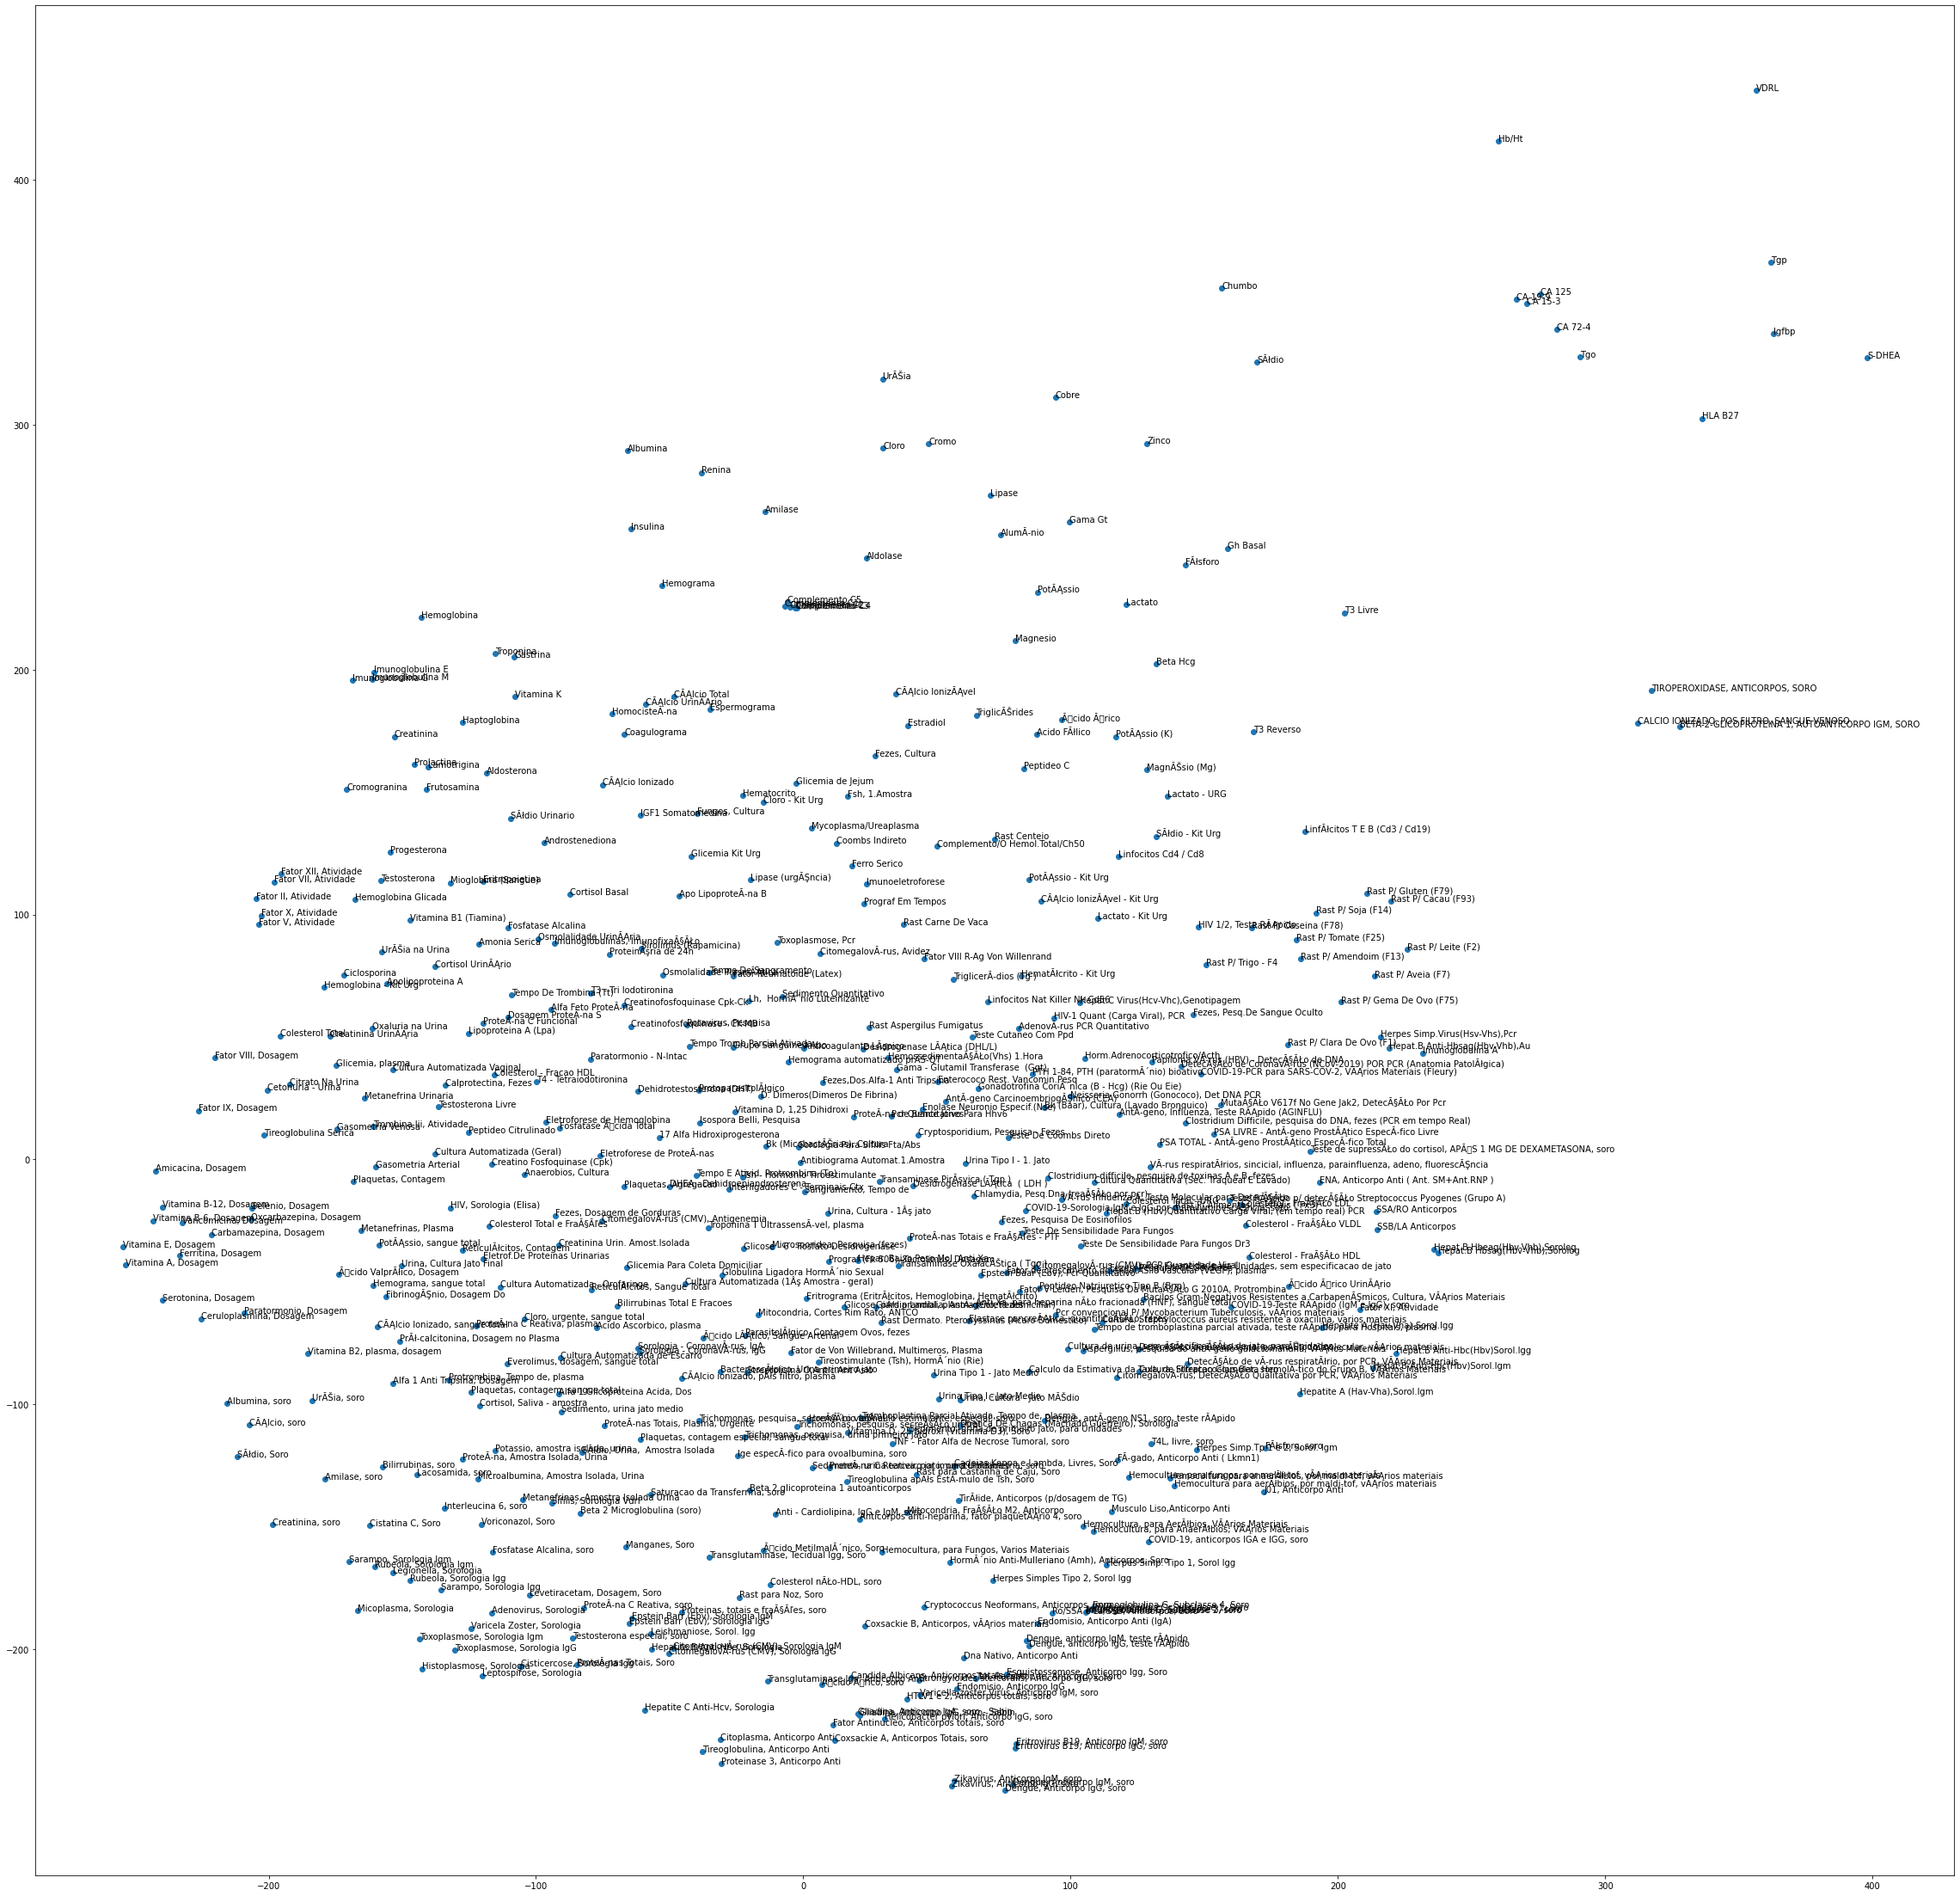

In [28]:
plt.rcParams['figure.figsize'] = 40, 40
plt.scatter(x=mds[:, 0], y=mds[:, 1])
for i, point in enumerate(mds):
    plt.annotate(all_exams[i], (point[0], point[1]))
plt.savefig('MDS_annotated')

### Clustering...

#### Finding our Epsilon through a histogram

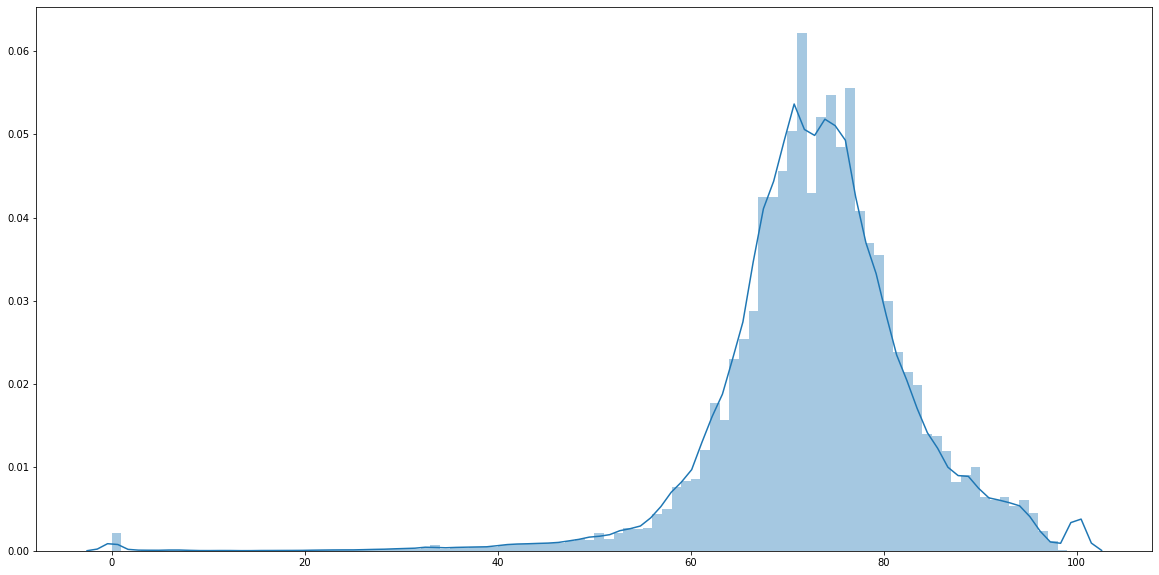

In [32]:
plt.rcParams['figure.figsize'] = 20, 10
distplot = sns.distplot(X, bins=np.arange(0, 100, 1));
distplot = distplot.get_figure()
distplot.savefig("adj_matrix_histogram")

By looking at the histogram, we can see that our current scenario is definitely not ideal for clustering, since our examples are all too close.

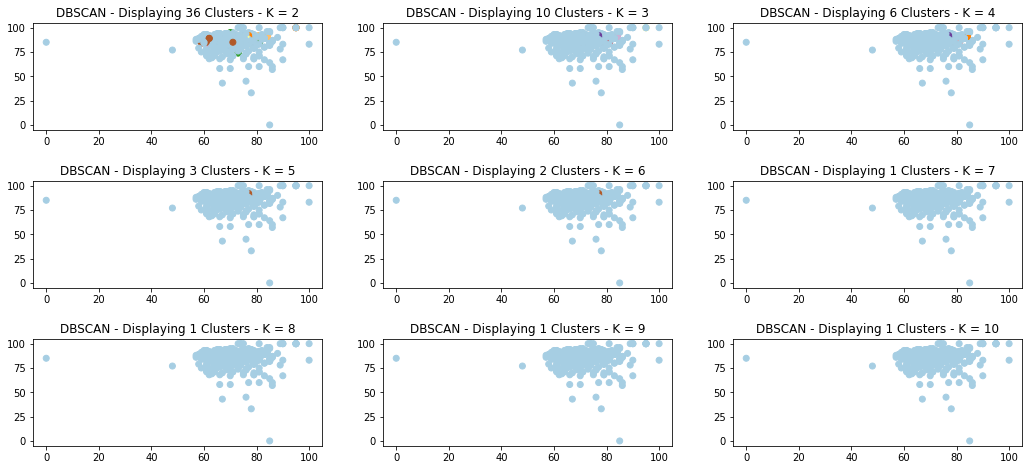

In [33]:
# Preparing our subplots..
plt.rcParams["figure.figsize"] = (15,7)
fig, axs = plt.subplots(3, 3)
fig.tight_layout(pad=3)

# A list with all values of K we're going to test...
ks = np.arange(2, 11)

count = 0

for i in range(3):
    for j in range(3):
        db = DBSCAN(eps=73, min_samples=ks[count]).fit(adj_matrix)
        y_pred = db.fit_predict(X)
        
        # Plotting...
        axs[i][j].scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
        axs[i][j].set_title(f"DBSCAN - Displaying {len(np.unique(db.labels_))} Clusters - K = {ks[count]}");
        
        count += 1
plt.savefig('DBSCAN_k_plot')

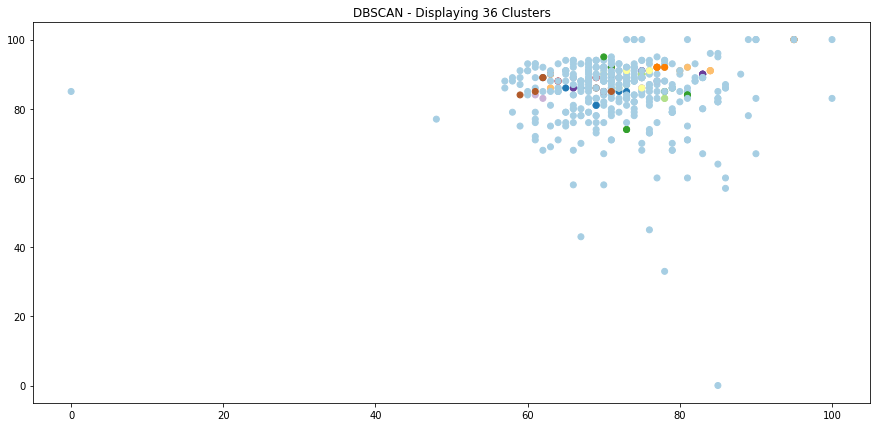

In [35]:
db = DBSCAN(eps=73, min_samples=2).fit(adj_matrix);
plt.rcParams["figure.figsize"] = (15,7);
y_pred = db.fit_predict(X);
plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired');
plt.title(f"DBSCAN - Displaying {len(np.unique(db.labels_))} Clusters");
plt.savefig('DBSCAN_K_EQUALS_2')